# Libraries

In [123]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import json
import time
import warnings
warnings.filterwarnings('ignore')
# Plotly template
import plotly.io as pio
pio.templates.default = "plotly_white"
pio.renderers.default = 'iframe'

# For dashboard examples
from IPython.display import HTML, display, IFrame, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, VBox, HBox

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
px.defaults.template = 'plotly_white'



# Functions

In [52]:
def load_and_prepare(csv):
    df= pd.read_csv(csv)
    df.columns = df.columns.str.replace(' ', '_')
    df = df.drop(columns = ['Trading_Date'])
    df['Trading_Interval'] = pd.to_datetime(df['Trading_Interval'], format = '%Y-%m-%d %H:%M:%S', errors = 'raise')
    df['Extracted_At'] = pd.to_datetime(df['Extracted_At'], format = '%Y-%m-%d %H:%M:%S', errors = 'raise')
    df['month_name'] = df['Trading_Interval'].dt.month_name()
    df['month_period'] = df['Trading_Interval'].dt.to_period('M')
    df['hour'] = df['Trading_Interval'].dt.hour
    return df
    

In [106]:
def plot_monthly_hourly_boxes(
    df,
    months,
    hours=range(7,18),             # 07:00..17:00
    ycol="Estimated_DPV_Generation_(MW)",
    month_col="month_name",
    hour_col="hour",
    title_fmt="{m} 2025: 07:00–17:00 Hourly",
    showfliers=False,
    sharey=True,
    figsize=(12,18),
    palette="husl"
):
    df = df.copy()
    # enforce month order and hour filter
    df[month_col] = pd.Categorical(df[month_col], categories=months, ordered=True)
    f = df[df[hour_col].isin(hours) & df[month_col].isin(months)]

    fig, axes = plt.subplots(len(months), 1, figsize=figsize, sharey=sharey)
    axes = np.atleast_1d(axes)

    last_ax = None
    for ax, m in zip(axes, months):
        d = f[f[month_col] == m]
        if d.empty:
            ax.set_visible(False); continue
        sns.boxplot(
            data=d,
            x=month_col, y=ycol, hue=hour_col,
            order=[m], showfliers=showfliers,
            ax=ax, palette=palette
        )
        ax.set_xlabel(title_fmt.format(m=m))
        ax.set_ylabel("DPV Est. Gen (MW)")
        # remove per-axes legend; we’ll add one global
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        last_ax = ax

    # one shared legend (hours)
    if last_ax and last_ax.has_data():
        handles, labels = last_ax.get_legend_handles_labels()
        fig.legend(handles, labels, title="Hour",
                   loc="center left", bbox_to_anchor=(0.98, 0.5), frameon=False)

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave space for legend
    return fig, axes

In [122]:
def plot_month_hour_boxes(df, months, hours=range(7,18)):
    d = df[df["hour"].isin(hours) & df["month_name"].isin(months)].copy()
    d["month_name"] = pd.Categorical(d["month_name"], categories=months, ordered=True)
    fig = px.box(
        d, x="hour", y="Estimated_DPV_Generation_(MW)",
        color="hour", points=False, facet_row="month_name",
        category_orders={"hour": list(hours), "month_name": months},
        labels={"hour":"Hour", "Estimated_DPV_Generation_(MW)":"DPV Est. Gen (MW)"}
    )
    fig.update_layout(height=200*len(months), width=1000, legend_title_text="Hour")
    fig.for_each_annotation(lambda a: a.update(text=a.text.replace("month_name=", "") + " 25: 07:00–17:00"))
    fig.update_traces(hovertemplate="Hour=%{x}<br>MW=%{y:.2f}<extra></extra>")
    return fig

# Load Data

In [53]:
distributed_dpv_2025 = load_and_prepare('distributed-pv-2025.csv')

In [54]:
distributed_dpv_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13008 entries, 0 to 13007
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Interval_Number                13008 non-null  int64         
 1   Trading_Interval               13008 non-null  datetime64[ns]
 2   Estimated_DPV_Generation_(MW)  13008 non-null  float64       
 3   Extracted_At                   1 non-null      datetime64[ns]
 4   month_name                     13008 non-null  object        
 5   month_period                   13008 non-null  period[M]     
 6   hour                           13008 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(1), period[M](1)
memory usage: 660.7+ KB


In [55]:
distributed_dpv_2025.head()

,Interval_Number,Trading_Interval,Estimated_DPV_Generation_(MW),Extracted_At,month_name,month_period,hour
0,1,2025-01-01 08:00:00,804.3500,2025-09-29 12:00:00,January,2025-01,8
1,2,2025-01-01 08:30:00,889.9797,NaT,January,2025-01,8
2,3,2025-01-01 09:00:00,1346.1300,NaT,January,2025-01,9
3,4,2025-01-01 09:30:00,1537.2360,NaT,January,2025-01,9
4,5,2025-01-01 10:00:00,1602.3790,NaT,January,2025-01,10


In [68]:
dpv_2025_month_stat = distributed_dpv_2025.groupby('month_name').agg({
    'Estimated_DPV_Generation_(MW)':['sum','min','mean','max']
}).round(2)
dpv_2025_month_stat.columns= ['Total_Generation_MW','Min_Generation_MW', 'Avg_Generation_MW', 'Max_Generation_MW']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']
dpv_2025_month_stat = dpv_2025_month_stat.reindex(month_order).reset_index()

In [62]:
dpv_2025_month_stat

,month_name,"Total_Generation,MW","Min_Generation,MW","Avg_Generation,MW","Max_Generation,MW"
0,January,926926.72,0.0,629.71,2262.14
1,February,846129.70,0.0,629.56,2336.58
2,March,505188.37,0.0,339.51,2257.87
3,April,602010.56,0.0,418.06,2088.30
4,May,516749.39,0.0,347.28,2005.29
5,June,492362.12,0.0,341.92,2088.68
6,July,476283.21,0.0,320.08,2349.46
7,August,837412.78,0.0,562.78,2620.50
8,September,841900.16,0.0,619.04,2643.06


In [71]:
dpv_2025_hour_stat = distributed_dpv_2025.groupby(['month_name','hour']).agg({
    'Estimated_DPV_Generation_(MW)':['sum','min','mean','max']
}).round(2)
dpv_2025_hour_stat.columns = ['Total_Generation_MW','Min_Generation_MW', 'Avg_Generation_MW', 'Max_Generation_MW']
dpv_2025_hour_stat = dpv_2025_hour_stat.reindex(month_order, level='month_name').reset_index()

In [73]:
dpv_2025_hour_stat.describe()

,hour,Total_Generation_MW,Min_Generation_MW,Avg_Generation_MW,Max_Generation_MW
count,216.000000,216.000000,216.000000,216.000000,216.000000
mean,11.500000,27985.940139,117.967222,467.615972,785.743009
std,6.938266,38533.222966,263.723323,648.119934,855.913204
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.750000,0.427500,0.000000,0.007500,0.240000
50%,11.500000,2551.320000,0.000000,43.175000,469.340000
75%,17.250000,59609.177500,1.027500,964.465000,1587.352500
max,23.000000,125172.670000,1285.210000,2156.060000,2643.060000


# Plots - Monthly

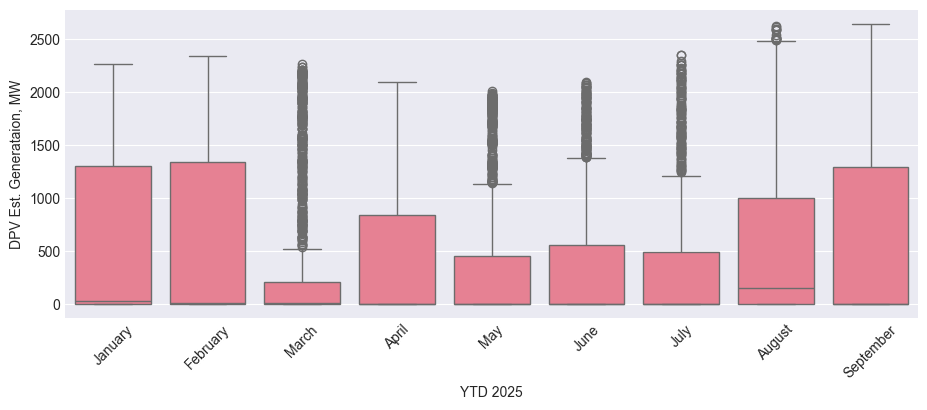

In [125]:
# plot with seaborn
fig, ax = plt.subplots(figsize = (11,4))
sns.boxplot(data = distributed_dpv_2025, x = 'month_name', y = 'Estimated_DPV_Generation_(MW)', ax = ax, whis = 1.5)
ax.set_xlabel('YTD 2025')
ax.set_ylabel('DPV Est. Generataion, MW')
ax.tick_params(axis='x', labelrotation=45)

In [107]:
df_plotly_monthly = distributed_dpv_2025.copy()
df_plotly_monthly['month_name']= pd.Categorical(df_plotly_monthly['month_name'], categories = month_order, ordered=True).astype(str)

In [127]:
# plot with plotly
fig = px.box(
    df_plotly_monthly, x = 'month_name', y = 'Estimated_DPV_Generation_(MW)',
    points='outliers',
    category_orders = {'month_name': month_order}
)
fig.update_layout(
    height=400, width=1000,
    xaxis_title='YTD 2025', yaxis_title='DPV Est.Generation (MW)',
    margin=dict(l=60, r=20, t=30, b=60)
)
fig.update_xaxes(tickangle=45)
fig.update_traces(hovertemplate = 'Month-%{x}<br>MW=%{y:.2f}<extra></extra>')
fig.show()

# Plot with Function - Hourly

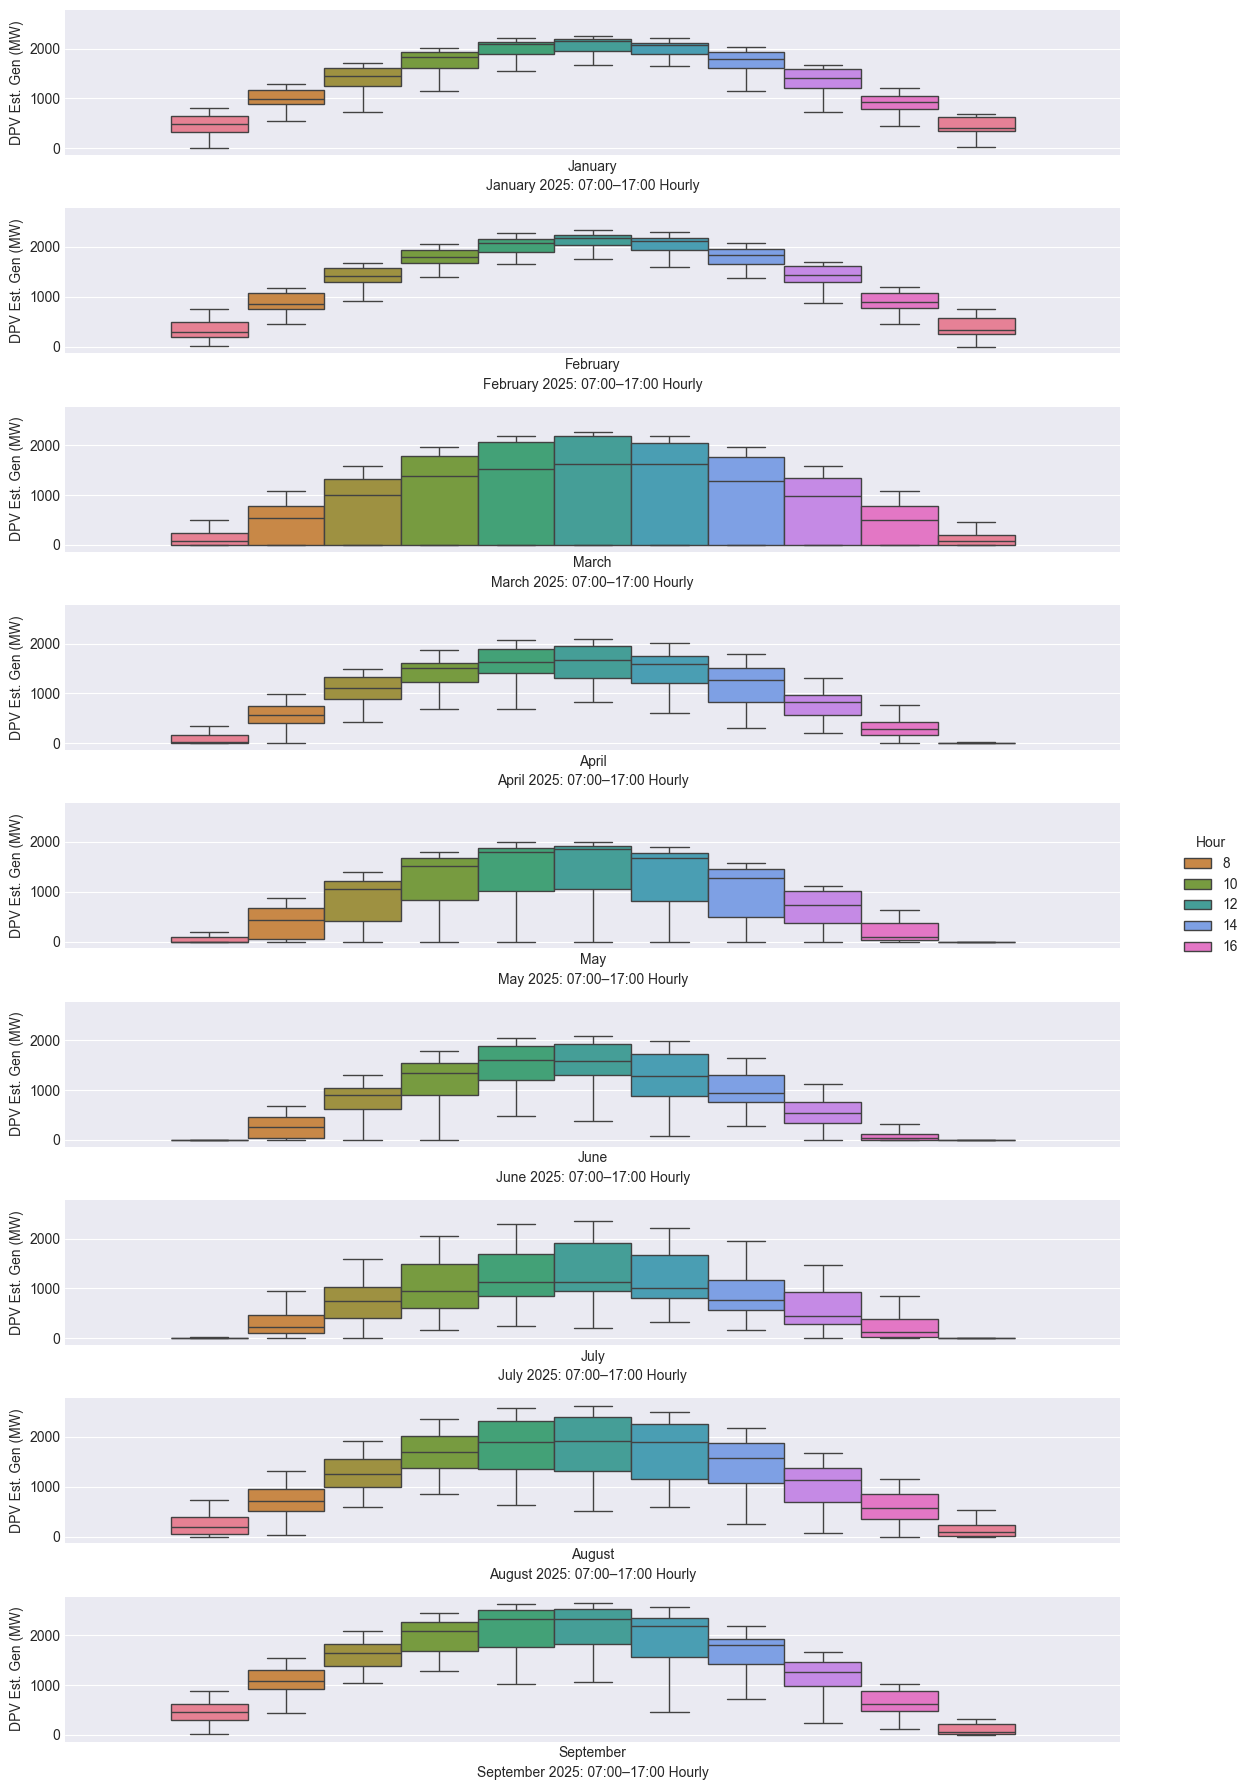

In [103]:
months = ["January","February","March","April","May","June","July","August","September"]
fig, axes = plot_monthly_hourly_boxes(distributed_dpv_2025, months)
plt.show()


In [118]:
def plot_month_hour_boxes(df, months, hours=range(7,18)):
    d = df[df["hour"].isin(hours) & df["month_name"].isin(months)].copy()
    d["month_name"] = pd.Categorical(d["month_name"], categories=months, ordered=True)
    fig = px.box(
        d, x="hour", y="Estimated_DPV_Generation_(MW)",
        color="hour", points=False, facet_row="month_name",
        category_orders={"hour": list(hours), "month_name": months},
        labels={"hour":"Hour", "Estimated_DPV_Generation_(MW)":"DPV Est. Gen (MW)"}
    )
    fig.update_layout(height=200*len(months), width=1000, legend_title_text="Hour")
    fig.for_each_annotation(lambda a: a.update(text=a.text.replace("month_name=", "") + " 25: 07:00–17:00"))
    fig.update_traces(hovertemplate="Hour=%{x}<br>MW=%{y:.2f}<extra></extra>")
    return fig

months_1_9 = ["January","February","March","April","May","June","July","August","September"]
fig = plot_month_hour_boxes(distributed_dpv_2025, months_1_9)
fig.show()


# Interactive Hourly Plot with Widgets

In [124]:
# --- Setup ---
df = distributed_dpv_2025.copy()
df["hour"] = pd.to_datetime(df["Trading_Interval"]).dt.hour if "hour" not in df else df["hour"]

month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
avail_months = [m for m in month_order if (df['month_name']==m).any()]

# Widgets
month_dd = widgets.Dropdown(options=avail_months, value=avail_months[0], description="Month")
hour_rng = widgets.IntRangeSlider(value=[7,17], min=0, max=23, step=1, description="Hour range")

out = widgets.Output()

def make_fig(month, hr_min, hr_max):
    d = df[(df["month_name"]==month) & (df["hour"].between(hr_min, hr_max))]
    d = d.copy()
    d["month_name"] = pd.Categorical(d["month_name"], categories=month_order, ordered=True)
    fig = px.box(
        d, x="hour", y="Estimated_DPV_Generation_(MW)",
        color="hour", points=False,
        category_orders={"hour": list(range(hr_min, hr_max+1))},
        labels={"hour":"Hour", "Estimated_DPV_Generation_(MW)":"DPV Est. Gen (MW)"}
    )
    fig.update_layout(
        title=f"{month} 2025: {hr_min:02d}:00–{hr_max:02d}:00",
        height=400, width=1000, legend_title_text="Hour", margin=dict(l=60, r=20, t=40, b=40)
    )
    fig.update_traces(hovertemplate="Hour=%{x}<br>MW=%{y:.2f}<extra></extra>")
    return fig

def update(_=None):
    with out:
        clear_output(wait=True)
        fig = make_fig(month_dd.value, hour_rng.value[0], hour_rng.value[1])
        fig.show()

# Wire up
month_dd.observe(update, names="value")
hour_rng.observe(update, names="value")

# Display UI
display(widgets.HBox([month_dd, hour_rng]))
display(out)
update()  # initial render


Output()

# Manual Plot Hourly

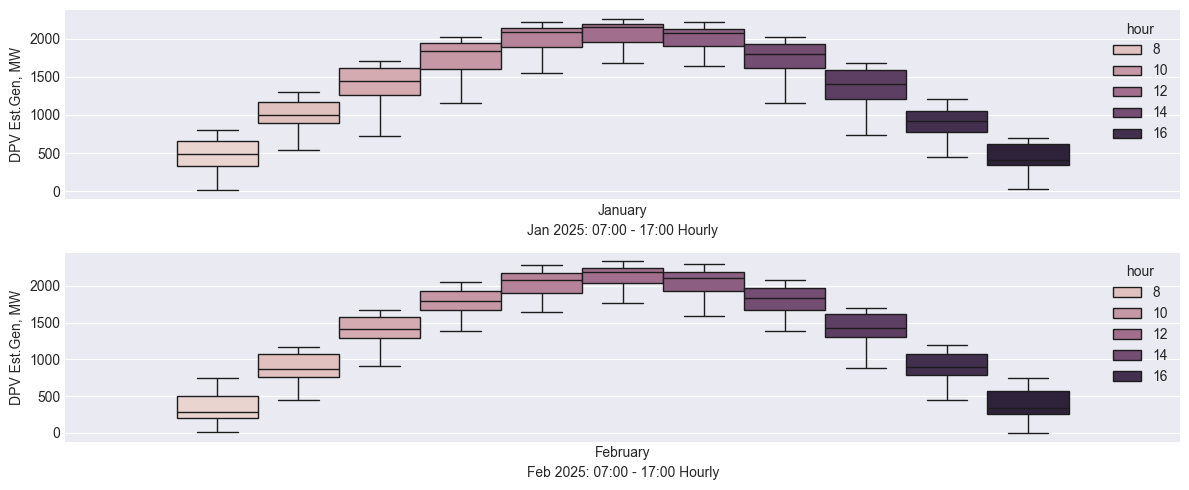

In [105]:
#manual plot with matplotlib & seaborn
fig, axes = plt.subplots(2,1, figsize = (12,5))
ax1 = axes[0]
hour_data_Jan = distributed_dpv_2025[(distributed_dpv_2025['hour'].isin([7,8,9,10,11,12,13,14,15,16,17])) & (distributed_dpv_2025['month_name']=='January')]
sns.boxplot(data = hour_data_Jan, x = 'month_name', y = 'Estimated_DPV_Generation_(MW)', hue = 'hour', ax = ax1,showfliers=False)
ax1.set_xlabel('Jan 2025: 07:00 - 17:00 Hourly')
ax1.set_ylabel('DPV Est.Gen, MW')

ax2 = axes[1]
hour_data_Feb = distributed_dpv_2025[(distributed_dpv_2025['hour'].isin([7,8,9,10,11,12,13,14,15,16,17])) & (distributed_dpv_2025['month_name']=='February')]
sns.boxplot(data = hour_data_Feb, x = 'month_name', y = 'Estimated_DPV_Generation_(MW)', hue = 'hour', ax = ax2,showfliers=False)
ax2.set_xlabel('Feb 2025: 07:00 - 17:00 Hourly')
ax2.set_ylabel('DPV Est.Gen, MW')

plt.tight_layout()


In [121]:
#manual plot with plotly
hrs = list(range(7,18))
months = ["January","February"]

df = distributed_dpv_2025.copy()
df = df[df["hour"].isin(hrs) & df["month_name"].isin(months)]
df["month_name"] = pd.Categorical(df["month_name"], categories=months, ordered=True)

fig = px.box(
    df,
    x="hour",                              # group by hour within each month
    y="Estimated_DPV_Generation_(MW)",
    color="hour",                          # legend shows hours
    points=False,                          # hide outlier dots
    facet_row="month_name",                # two rows: Jan, Feb
    category_orders={"hour": hrs, "month_name": months},
    labels={"hour":"Hour", "Estimated_DPV_Generation_(MW)":"DPV Est. Gen (MW)"}
)
fig.update_layout(
    height=450, width=1000,
    showlegend=True, legend_title_text="Hour",
    margin=dict(l=60, r=20, t=40, b=40)
)
# Titles like your xlabels
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("month_name=", "") + " 25: 07:00–17:00"))
fig.update_traces(hovertemplate="Hour=%{x}<br>MW=%{y:.2f}<extra></extra>")
fig.show()
